In [2]:
import os
# os.chdir("C:\\Users\\kosmo-18\\Desktop")


# 기본
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import font_manager as fm
from matplotlib import rc
import matplotlib

import re

# 시간 관련
from datetime import datetime, date, timedelta
import time


# 크롤링 관련
import requests
from bs4 import BeautifulSoup as bs
from urllib.request import urlopen
from selenium import webdriver
from selenium.webdriver.common.keys import Keys
from selenium.webdriver.common.action_chains import ActionChains
import pyautogui as  pag

# 트위터 업로드
import tweepy

# sql
import sqlite3


from eunjeon import Mecab
from wordcloud import WordCloud


import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
 
# spacy for lemmatization    
import spacy


# Plotting tools
import pyLDAvis
import pyLDAvis.gensim # don't skip this

ModuleNotFoundError: No module named 'pyautogui'

# 트위터 업로드

In [ ]:
# 트위터 업로드
CONSUMER_KEY = "VQEIheSVWjY4PO2cqs0QPva27"
CONSUMER_SECRET = "m8mkQK4OmteZMAK6fMYEV8BBAOtoHU1K3vW8hCZXueiogSLCEt"
ACCESS_TOKEN = "1899633146-EbPmRDkDMtlMgiKf28MpS2lru0sf8vbFwbuxASy"
ACCESS_TOKEN_SECRET = "efbd2EgazZpWSeHiOpkRr3B3th8osNGJUSknhk1utO3lK"

# Authenticate to Twitter
auth = tweepy.OAuthHandler(CONSUMER_KEY, CONSUMER_SECRET)
auth.set_access_token(ACCESS_TOKEN, ACCESS_TOKEN_SECRET)

# Create API object
api = tweepy.API(auth)

try:
    api.verify_credentials()
    print("Authentication OK")
except:
    print("Error during authentication")

# 지역 코드 불러오기

In [96]:
# 지역 코드
ji_code = pd.read_excel("C:/Users/kosmo-18/Desktop/KIKcd_B.20180122.xlsx")

seoul = ji_code[(ji_code['시도명']=='서울특별시')][['시도명','시군구명','읍면동명']]
seoul = seoul.dropna().reset_index(drop = True)

ji_code = ji_code[(ji_code["시도명"]=="서울특별시")]     # 서울로 한정
ji_code = ji_code[ji_code["읍면동명"].isnull()==True]
ji_code = ji_code[ji_code["시군구명"].isnull() == False]
ji_code["gu_code"] = ji_code["법정동코드"].astype(str).str[0:5]
ji_code = ji_code[['시도명', '시군구명', 'gu_code']]
ji_code.columns = ['si','gu','gu_code']
ji_code = ji_code.reset_index(drop = True)

# 국토교통부 부동산 실거래가 오픈 API 크롤러

In [6]:
def get_api_data(ym, lawd_cd):
    
    API_key = 'hzX4p1DWRKrur09ldIsJdMt26RWuJyF3cnkpP5NJtt70X9EiqQQrGfGClNqTQAQfA%2BfnFBx8zErcgNIO2tB41g%3D%3D'
    endpoint = 'http://openapi.molit.go.kr/OpenAPI_ToolInstallPackage/service/rest/RTMSOBJSvc/getRTMSDataSvcAptTradeDev'
    url = endpoint + "?serviceKey=" + API_key + "&pageNo=1" + "&numOfRows=5000" + \
            "&LAWD_CD=" + lawd_cd + "&DEAL_YMD=" + ym
    
    resultXML = urlopen(url)
    result = resultXML.read()
    xmlsoup = bs(result, 'lxml-xml')
    te = xmlsoup.find_all('item')

    df = pd.DataFrame()
    for t in te:
        gu_code = t.find('법정동시군구코드').text
        dong = t.find('법정동').text
        apt = t.find('아파트').text
        year = t.find('년').text
        month = t.find('월').text
        day = t.find('일').text
        area = t.find('전용면적').text
        price = int(t.find('거래금액').text.replace(',',''))
        if int(month) < 10: month = '0' + month
        if int(day) < 10: day = '0' + day
        date = year + month + day
        if area <= '59': size = '중소형' 
        elif area <= '84': size = '중대형' 
        else: size = '초대형'
            
        temp = pd.DataFrame(([[gu_code, dong, apt, date, area, price, size]]),
                        columns=["gu_code", "dong", "apt", "date", "area", "price", "size"])
        df = pd.concat([df,temp])
        
    df = df.reset_index(drop = True)
    
    return df



###### 위에는 api 데이터 수집, 여기는 데이터 저장
    
def get_estate_sil_data():
    
    # 초기 1년치 수집용, 한 번 구축한 후에는 당월만 수집하면 됨.
    today = datetime.today()
    
    time = [today.strftime('%Y%m%d')[:6],
            '202001', '201912', '201911', '201910', '201909', '201908', '201907',  #여기
            '201906', '201905','201904', '201903', '201902', '201901'] #랑 여기는 1회 실시후 제거


    # 데이터 저장
    df_trade = pd.DataFrame()
    for t in time:
        for co in code['gu_code']:
            temp = get_api_data(t, co)
            df_trade = pd.concat([df_trade, temp])

    df_trade = df_trade.reset_index(drop = True)
    df_trade['area'] = df_trade['area'].apply(lambda x : int(x) if x.find('.') <0
                                                else int(x[0:x.find('.')]))
    df_trade['pyeong'] = df_trade['area'].apply(lambda x : x / 3.3)
    
    df_trade['size'] = df_trade['area'].apply(lambda x : '중소형' if x <=59
                                  else '중대형' if x <=84
                                  else '초대형')
    df_trade['price_per_3.3'] = (df_trade['price'] / df_trade['pyeong']).round()

    df_trade = pd.merge(code, df_trade, on='gu_code', how='right').drop('gu_code', axis=1)
    
    return df_trade

# kb리브온 아파트 매물 정보 크롤러

In [9]:
def get_kb_data():
    
    # 원하는 구, 동 읽기 - for문으로 반복해서 전체를 읽을 수 있음.
    gu = ji_code['si'] + ' ' + ji_code['gu']
    dong = seoul['시도명'] + ' ' + seoul['시군구명'] + ' ' + seoul['읍면동명']
    
    # kb리브온 사이트 켜기
    driver = webdriver.Chrome('C:/chromedriver')
    driver.implicitly_wait(3) #암묵적으로 웹 자원 로드를 위해 3초까지 기다려 준다.
    driver.get('https://onland.kbstar.com/quics?page=C059652')
    
    # 연습용 - 개포동만 검색. 실제로는 gu, dong 이용해서
    action = ActionChains(driver)
    search = driver.find_element_by_xpath('//*[@id="unifiedSearchKeyword"]')
    action.move_to_element(search).click().send_keys('서울특별시 강남구 개포동').send_keys(Keys.RETURN).perform()
    
    # 동 검색 결과 (아래에 생김) 클릭
    action = ActionChains(driver)
    step_1 = driver.find_element_by_xpath('//*[@id="unifiedSearchResult"]/div[1]/ul/li/a/b[1]')
    action.move_to_element(step_1).click().perform()

    # 거래유형 클릭
    action = ActionChains(driver)
    step_2 = driver.find_element_by_xpath('//*[@id="IBF"]/div/div[3]/div[1]')
    action.move_to_element(step_2).click().perform()

    # 거래유형 중 매매 클릭
    action = ActionChains(driver)
    step_3 = driver.find_element_by_xpath('//*[@id="IBF"]/div/div[3]/div[2]/div/div/div[1]/ul/li[2]/label/span[1]')
    action.move_to_element(step_3).click().perform()

    # 거래유형 닫기
    action = ActionChains(driver)
    step_4 = driver.find_element_by_xpath('//*[@id="IBF"]/div/div[3]/div[1]')
    action.move_to_element(step_4).click().perform()
    
    # 매물종류 클릭
    action = ActionChains(driver)
    step_5 =  driver.find_element_by_xpath('//*[@id="IBF"]/div/div[2]/div[1]')
    action.move_to_element(step_5).click().perform()
    
    # 매물종류 중 오피스텔 해제
    action = ActionChains(driver)
    step_6 =  driver.find_element_by_xpath('//*[@id="IBF"]/div/div[2]/div[2]/div/div/div[1]/ul/li[2]/label')
    action.move_to_element(step_6).click().perform()
    
    # 최신순 클릭
    action = ActionChains(driver)
    step_7 = driver.find_element_by_xpath('//*[@id="maemulTab"]/a[2]')
    action.move_to_element(step_7).click().perform()
    
    time.sleep(10)
    
    # 아래 매물까지 보기 위해 스크롤 클릭 후 내리기
    pag.moveTo(383,409)
    pag.mouseDown()
    for i in range(100):
        pag.moveTo(1594 ,1070) 
        time.sleep(1)
        pag.moveTo(94 ,1070)
    pag.mouseUp()
    
    # 파싱
    html = driver.page_source
    soup = bs(html, 'lxml')
    lis = soup.select('#mCSB_19_container > .map_mod_list')  # 개별 list쪽 크롤링 


    today = datetime.today().strftime("%Y%m%d")
    korean = re.compile('[\u3131-\u3163\uac00-\ud7a3]+')


    apt, price, area, date = [], [], [], []
    count = -1
    for i in lis:
        count += 1

        apt.append(i.find('dt').text)
        price.append(i.find('dd',{'class':'sprice'}).text[2:].replace(',',''))
        area.append(i.find('span',{'class':'ellips'}).find('span').text)
        prior_date = (i.find('dd',{'class':'mod_btn'}).text).lstrip()
        date.append(prior_date[prior_date.find(' ')+1 : prior_date.find(' ')+9])

# 아래 주석 코드는 향후 반복작업 할 때 크롤링 날짜 주기 계산 후 수정해서 작업
#         if (int(today) - int('20' + date[count].replace('.',''))) > 14:
#             break 

    driver.quit()
    
    estate = pd.DataFrame({'apt':apt, 'date':date, 'area':area, 'price':price})
    #estate = estate.iloc[:-1,:] 
    estate['date'] = estate['date'].apply(lambda x : '20' + x.replace('.',''))
    estate['area'] = estate['area'].apply(lambda x : int(x[x.find('/') + 1 : -2]))
    estate['pyeong'] = estate['area'].apply(lambda x : x / 3.3)
    estate['size'] = estate['area'].apply(lambda x : '중소형' if x <= 59
                                          else '중대형' if x <=84
                                          else '초대형')   
    estate['price'] = estate['price'].apply(lambda x : (int(x[: x.find('억')] + '00000') + \
                                                        int(x[x.find('억')+1:] +'0')) / 10 if x.find('억') > 0 
                                                        else int(x))
    
    estate['price_per_3.3'] = (estate['price'] / estate['pyeong']).round()
    
    
    return estate

In [111]:
df_kb_estate = get_kb_data()

KeyboardInterrupt: 

In [110]:
def get_kb_data():
    
    # 원하는 구, 동 읽기 - for문으로 반복해서 전체를 읽을 수 있음.
    gu = ji_code['si'] + ' ' + ji_code['gu']
    dong = seoul['시도명'] + ' ' + seoul['시군구명'] + ' ' + seoul['읍면동명']
    
    for g in gu:

        # kb리브온 사이트 켜기
        driver = webdriver.Chrome('C:/chromedriver')
        driver.implicitly_wait(3) #암묵적으로 웹 자원 로드를 위해 3초까지 기다려 준다.
        driver.get('https://onland.kbstar.com/quics?page=C059652')

        # 연습용 - 개포동만 검색. 실제로는 gu, dong 이용해서
        action = ActionChains(driver)
        search = driver.find_element_by_xpath('//*[@id="unifiedSearchKeyword"]')
        action.move_to_element(search).click().send_keys(g).send_keys(Keys.RETURN).perform()

        # 동 검색 결과 (아래에 생김) 클릭
        action = ActionChains(driver)
        step_1 = driver.find_element_by_xpath('//*[@id="unifiedSearchResult"]/div[1]/ul/li/a/b[1]')
        action.move_to_element(step_1).click().perform()

        # 거래유형 클릭
        action = ActionChains(driver)
        step_2 = driver.find_element_by_xpath('//*[@id="IBF"]/div/div[3]/div[1]')
        action.move_to_element(step_2).click().perform()

        # 거래유형 중 매매 클릭
        action = ActionChains(driver)
        step_3 = driver.find_element_by_xpath('//*[@id="IBF"]/div/div[3]/div[2]/div/div/div[1]/ul/li[2]/label/span[1]')
        action.move_to_element(step_3).click().perform()

        # 거래유형 닫기
        action = ActionChains(driver)
        step_4 = driver.find_element_by_xpath('//*[@id="IBF"]/div/div[3]/div[1]')
        action.move_to_element(step_4).click().perform()

        # 매물종류 클릭
        action = ActionChains(driver)
        step_5 =  driver.find_element_by_xpath('//*[@id="IBF"]/div/div[2]/div[1]')
        action.move_to_element(step_5).click().perform()

        # 매물종류 중 오피스텔 해제
        action = ActionChains(driver)
        step_6 =  driver.find_element_by_xpath('//*[@id="IBF"]/div/div[2]/div[2]/div/div/div[1]/ul/li[2]/label')
        action.move_to_element(step_6).click().perform()

        # 최신순 클릭
        action = ActionChains(driver)
        step_7 = driver.find_element_by_xpath('//*[@id="maemulTab"]/a[2]')
        action.move_to_element(step_7).click().perform()

        time.sleep(7)

        # 아래 매물까지 보기 위해 스크롤 클릭 후 내리기
        pag.moveTo(383,409)
        pag.mouseDown()
        for i in range(100):
            pag.moveTo(1594 ,1070) 
            time.sleep(1)
            pag.moveTo(94 ,1070)
        pag.mouseUp()

        # 파싱
        html = driver.page_source
        soup = bs(html, 'lxml')
        lis = soup.select('#mCSB_19_container > .map_mod_list')  # 개별 list쪽 크롤링 


        today = datetime.today().strftime("%Y%m%d")
        korean = re.compile('[\u3131-\u3163\uac00-\ud7a3]+')


        gu, apt, price, area, date = [], [], [], [], []
        count = -1
        for i in lis:
            count += 1

            gu.append(g)
            apt.append(i.find('dt').text)
            price.append(i.find('dd',{'class':'sprice'}).text[2:].replace(',',''))
            area.append(i.find('span',{'class':'ellips'}).find('span').text)
            prior_date = (i.find('dd',{'class':'mod_btn'}).text).lstrip()
            date.append(prior_date[prior_date.find(' ')+1 : prior_date.find(' ')+9])
            
    # 아래 주석 코드는 향후 반복작업 할 때 크롤링 날짜 주기 계산 후 수정해서 작업
    #         if (int(today) - int('20' + date[count].replace('.',''))) > 14:
    #             break 
        driver.quit()

        
    estate = pd.DataFrame({'gu':gu, 'apt':apt, 'date':date, 'area':area, 'price':price})
    #estate = estate.iloc[:-1,:] 
    estate['date'] = estate['date'].apply(lambda x : '20' + x.replace('.',''))
    estate['area'] = estate['area'].apply(lambda x : int(x[x.find('/') + 1 : -2]))
    estate['pyeong'] = estate['area'].apply(lambda x : x / 3.3)
    estate['size'] = estate['area'].apply(lambda x : '중소형' if x <= 59
                                              else '중대형' if x <=84
                                              else '초대형')   
    estate['price'] = estate['price'].apply(lambda x : (int(x[: x.find('억')] + '00000') + \
                                                        int(x[x.find('억')+1:] +'0')) / 10 if x.find('억') > 0 
                                                        else int(x))

    estate['price_per_3.3'] = (estate['price'] / estate['pyeong']).round()

    
    
    return estate

# 네이버뉴스 (부동산) 크롤러

In [107]:
def get_estate_news():
    
    
    # 부동산 뉴스 기본 url
    url_base = 'https://news.naver.com/main/list.nhn?mode=LS2D&mid=shm&sid2=260&sid1=101&date='
    
    # 기사 작성일 기준 전날부터 일주일을 분석하기 위해 날짜 생성
    dates = []
    for i in range(7):
        dates.append((datetime.today()- timedelta(days = i+1)).strftime("%Y%m%d"))
    
    
    # 기사 크롤러 시작   :  일자별(7일), 페이지별(1 ~ 마지막페이지), 각 기사별 크롤링. 순서는 역순.
    title, content = [], []
    for dt in dates:   # 7일 반복
        
        lis = []
        for page in range(1,50): # 10페이지가 넘어갈 경우 반복하여 1~10페이지 파싱
            url = url_base + dt + '&page=' + str(page) # 각 페이지별 url 주소 입력
            html = urlopen(url).read() # 각 페이지별 url 읽기.
            xmlsoup = bs(html, 'html.parser') # 파싱

            lis.append(xmlsoup.select('#main_content > div.list_body.newsflash_body > \
                                ul.type06_headline > li')) # 기사 list
            if page == 1:
                pass
            else:
                if lis[page-1] == lis[page-2]: #지금 보는 페이지가 전과 같으면 멈춤.
                    break
            
            for i in lis[page-1]: # list 내 기사 링크로 이동하여 제목과 내용 크롤링
                link = i.find('a', attrs = {'href':re.compile('^https://')}).get('href')
                news = urlopen(link).read()
                newssoup = bs(news, 'html.parser')

                title.append(newssoup.select('#articleTitle')[0].text)
                content.append(newssoup.select('#articleBodyContents')[0].text)
                
    
    df_news = pd.DataFrame({'title':title, 'content':content})
    df_news['content'] = df_news['content'].apply(lambda x : ' '.join(x.replace("// flash 오류를 우회하기 위한 함수 추가 function _flash_removeCallback() {}", "").split()))
    
    return df_news

# 함수 만들기 끝 아래는 실행 및 전처리

In [ ]:
# 부동산 실거래가 저장 및 전처리
df_sil_trade = get_estate_sil_data()

df_sil_trade['week'] = df_sil_trade['date'].apply(lambda x : 1 if x < wk_1.strftime("%Y%m%d")
                                                  else 2 if x < wk_2.strftime("%Y%m%d")
                                                  else 3 if x < wk_3.strftime("%Y%m%d")
                                                  else 4 if x < wk_4.strftime("%Y%m%d")
                                                  else 5 if x < wk_5.strftime("%Y%m%d")
                                                  else 6 if x < wk_6.strftime("%Y%m%d")
                                                  else 7 if x < wk_7.strftime("%Y%m%d")
                                                  else 8 if x < wk_8.strftime("%Y%m%d")
                                                  else 9 if x < wk_9.strftime("%Y%m%d")
                                                  else 10 if x < wk_10.strftime("%Y%m%d")
                                                  else 11 if x < wk_11.strftime("%Y%m%d")
                                                  else 12 if x < wk_12.strftime("%Y%m%d")
                                                  else 13
                                                 )
this_month_price_by_dong = df_sil_trade[df_sil_trade['date'] > four_month_ago.strftime("%Y%m%d")].groupby('gu', as_index=False).agg('median')
this_month_price_by_dong = this_month_price_by_dong[['gu', 'price_per_3.3']]

last_month_price_by_dong = df_sil_trade[df_sil_trade['date'] <= four_month_ago.strftime("%Y%m%d")].groupby('gu', as_index=False).agg('median')
last_month_price_by_dong = last_month_price_by_dong[['gu', 'price_per_3.3']]


price_change_by_dong = pd.merge(this_month_price_by_dong, last_month_price_by_dong, on='gu', how = 'outer')

price_change_by_dong['price_change'] = (price_change_by_dong['price_per_3.3_x'] - \
                                        price_change_by_dong['price_per_3.3_y']) / price_change_by_dong['price_per_3.3_x']
price_change_by_dong.dropna(inplace=True)
price_change_max_dong = price_change_by_dong[price_change_by_dong['price_change']==max(price_change_by_dong['price_change'])]
price_change_min_dong = price_change_by_dong[price_change_by_dong['price_change']==min(price_change_by_dong['price_change'])]


df_sil_trade2 = df_sil_trade[df_sil_trade['dong']==' 개포동']
# 이번주 평당 가격 평균가, 거래건수, 규모별 평균가, 거래건수
this_wk_price = df_sil_trade2[df_sil_trade2['date'] >= this_week]['price_per_3.3'].median()

this_wk_trade_num =  df_sil_trade2[df_sil_trade2['date'] >= this_week].count()[0]

this_wk_price_by_size = df_sil_trade2[df_sil_trade2['date'] >= this_week].groupby('size', as_index=False).agg('median')
this_wk_price_by_size = this_wk_price_by_size[['size', 'price_per_3.3']]

this_wk_trade_num_by_size = df_sil_trade2[df_sil_trade2['date'] >= this_week].groupby('size', as_index=False).agg('count')
this_wk_trade_num_by_size = this_wk_trade_num_by_size[['size','si']].rename({'si':'count'}, axis=1)

# 저번주 평당 가격 평균가, 규모별 평균가
last_wk_price = df_sil_trade2[(df_sil_trade2['date'] >= last_week) & (df_sil_trade2['date'] < this_week)]['price_per_3.3'].median()

last_wk_trade_num =  df_sil_trade2[(df_sil_trade2['date'] >= last_week) & (df_sil_trade2['date'] < this_week)].count()[0]

last_wk_price_by_size = df_sil_trade2[(df_sil_trade2['date'] >= last_week) & (df_sil_trade2['date'] < this_week)].groupby('size', as_index=False).agg('median')
last_wk_price_by_size = last_wk_price_by_size[['size', 'price_per_3.3']]

last_wk_trade_num_by_size = df_sil_trade2[(df_sil_trade2['date'] >= last_week) & (df_sil_trade2['date'] < this_week)].groupby('size', as_index=False).agg('count')
last_wk_trade_num_by_size = last_wk_trade_num_by_size[['size','si']].rename({'si':'count'}, axis=1)

# 지난주 대비 증감 금액, 거래건수
price_change = this_wk_price - last_wk_price
trade_num_change = this_wk_trade_num - last_wk_trade_num
price_change_by_size = pd.DataFrame({'change_price_by_size' : this_wk_price_by_size['price_per_3.3'] - last_wk_price_by_size['price_per_3.3']})
trade_num_change_by_size = pd.DataFrame({'change_trade_num_by_size' : this_wk_trade_num_by_size['count'] - last_wk_trade_num_by_size['count']})

price_by_size = pd.concat([this_wk_price_by_size, price_change_by_size], axis=1)
trade_num_by_size = pd.concat([this_wk_trade_num_by_size, trade_num_change_by_size], axis=1)


# this_wk_price #이번주 실거래가 평당 평균 가격
# this_wk_trade_num #이번주 거래 건수
# this_wk_price_by_size #이번주 규모별 실거래가 평당 평균 가격
# this_wk_trade_num_by_size #이번주 규모별 거래 건수

# last_wk_price # 저번주 실거래가 평당 평균 가격
# last_wk_trade_num # 저번주 거래 건수
# last_wk_price_by_size # 저번주 규모별 실거래가 평당 평균 가격
# last_wk_trade_num_by_size # 저번주 규모별 거래 건수

# price_change # 저번주 대비 이번주 가격 증감액
# trade_num_change # 저번주 대비 이번주 거래 증감수
# price_change_by_size # 저번주 대비 이번주 규모별 가격 증감액
# trade_num_change_by_size # 저번주 대비 이번주 규모별 거래 증감수

# price_change_by_dong # 동별 2달 전 대비 1달전 가격 등락률
# price_change_max_dong # 동별 2달 전 대비 1달전 가격 등락률 최대
# price_change_min_dong # 동별 2달 전 대비 1달전 가격 등락률 최소

In [ ]:
# 
today = datetime.today()
month_ago = datetime.today().replace(day = 1) - timedelta(days = 1)
two_month_ago = month_ago.replace(day = 1) - timedelta(days = 1)
three_month_ago = two_month_ago.replace(day = 1) - timedelta(days = 1)
four_month_ago = three_month_ago.replace(day = 1) - timedelta(days = 1)
five_month_ago = four_month_ago.replace(day = 1) - timedelta(days = 1)

# 이번주 처음 날짜, 저번주 처음 날짜
this_week = (today- timedelta(days = 7)).strftime("%Y%m%d")
last_week = (today- timedelta(days = 14)).strftime("%Y%m%d")


# 지난 3개월 주별 날짜
wk_13 = today.replace(day=1) - timedelta(days=1)
wk_12 = wk_13 - timedelta(days=7)
wk_11 = wk_12 - timedelta(days=7)
wk_10 = wk_11 - timedelta(days=7)
wk_9 = wk_10 - timedelta(days=7)
wk_8 = wk_9 - timedelta(days=7)
wk_7 = wk_8 - timedelta(days=7)
wk_6 = wk_7 - timedelta(days=7)
wk_5 = wk_6 - timedelta(days=7)
wk_4 = wk_5 - timedelta(days=7)
wk_3 = wk_4 - timedelta(days=7)
wk_2 = wk_3 - timedelta(days=7)
wk_1 = wk_2 - timedelta(days=7)

datetime.datetime(2019, 11, 23, 9, 20, 31, 744014)

# 여기부터 시작

# SQL DB에 저장

In [112]:
# 네이버 뉴스 (부동산)
df_news = get_estate_news()
df_news['content'] = df_news['content'].apply(lambda x : ' '.join(x.replace("// flash 오류를 우회하기 위한 함수 추가 function _flash_removeCallback() {}", "").split()))

In [12]:
# 실거래가
df_sil_trade = get_estate_sil_data()

In [13]:
# kb리브온
df_kb_estate= get_kb_data()

In [ ]:
# db저장
con = sqlite3.connect("./project2_estate/real_estate2.db")

df_kb_estate.to_sql('kb_estate', con, if_exists='append', index=False)
df_sil_trade.to_sql('sil_trade', con, if_exists='append', index=False)
df_news.to_sql('news', con, if_exists='append', index=False)

con.close()

# DB에서 데이터 불러오기

In [ ]:
# kb리브온

In [31]:
today = datetime.today()
last_30 = (today - timedelta(days=30)).strftime("%Y%m%d")
last_60 = (today - timedelta(days=60)).strftime("%Y%m%d")

month_ago = datetime.today().replace(day = 1) - timedelta(days = 1)
two_month_ago = month_ago.replace(day = 1) - timedelta(days = 1)
three_month_ago = two_month_ago.replace(day = 1) - timedelta(days = 1)
four_month_ago = three_month_ago.replace(day = 1) - timedelta(days = 1)

In [32]:
con = sqlite3.connect("./project2_estate/real_estate2.db")

cur = con.cursor()
cur.execute("select distinct * from kb_estate")


names, contents = [],[]
colnames = cur.description
for row in colnames:
    names.append(row[0])
    
rows = cur.fetchall()
for row in rows:
    contents.append(row)

con.close()


df_kb = pd.DataFrame(data=contents, columns=names)

In [33]:
# 최근 30일 평당 가격 평균가, 거래건수, 규모별 가격, 규모별 거래건수
kb_30_price = df_kb[df_kb['date'] >= last_30]['price_per_3.3'].mean()

kb_30_tr_num =  df_kb[df_kb['date'] >= last_30].count()[0]

kb_30_price_by_size = df_kb[df_kb['date'] >= last_30].groupby('size', as_index=False).agg('mean')
kb_30_price_by_size = kb_30_price_by_size[['size', 'price_per_3.3']]

kb_30_tr_num_by_size = df_kb[df_kb['date'] >= last_30].groupby('size', as_index=False).agg('count')
kb_30_tr_num_by_size = kb_30_tr_num_by_size[['size','apt']].rename({'apt':'count'},axis=1)

# 30~60일 평당 가격 평균가, 거래건수, 규모별 가격, 규모별 거래건수
kb_60_price = df_kb[(df_kb['date'] < last_30) & (df_kb['date'] >= last_60) ]['price_per_3.3'].median()

kb_60_tr_num = df_kb[(df_kb['date'] < last_30) & (df_kb['date'] >= last_60) ].count()[0]

kb_60_price_by_size =  df_kb[(df_kb['date'] < last_30) & (df_kb['date'] >= last_60) ].groupby('size', as_index=False).agg('median')
kb_60_price_by_size = kb_60_price_by_size[['size', 'price_per_3.3']]

kb_60_tr_num_by_size = df_kb[(df_kb['date'] < last_30) & (df_kb['date'] >= last_60) ].groupby('size', as_index=False).agg('count')
kb_60_tr_num_by_size = kb_60_tr_num_by_size[['size','apt']].rename({'apt':'count'},axis=1)

# 60~30일 전 대비 30~0일 가격, 거래건수, 규모별 가격, 규모별 거래건수 변화
kb_price_change = kb_30_price - kb_60_price
kb_tr_num_change = kb_30_tr_num - kb_60_tr_num

kb_price_change_by_size = pd.merge(kb_30_price_by_size, kb_60_price_by_size, on='size', how='outer')
kb_price_change_by_size['price_change'] = kb_price_change_by_size.iloc[:,1] - kb_price_change_by_size.iloc[:,2]
kb_price_change_by_size = kb_price_change_by_size[['size','price_change']]

kb_tr_num_change_by_size = pd.merge(kb_30_tr_num_by_size, kb_60_tr_num_by_size, on='size', how='outer')
kb_tr_num_change_by_size['price_change'] = kb_tr_num_change_by_size.iloc[:,1] - kb_tr_num_change_by_size.iloc[:,2]
kb_tr_num_change_by_size = kb_tr_num_change_by_size[['size','price_change']]





kb_30_price # 최근 30일 등록매물 가격 (평당 평균가)
kb_30_tr_num # 최근 30일 등록매물 건수
kb_30_price_by_size # 최근 30일 규모별 등록매물 가격  (평당 평균가)
kb_30_tr_num_by_size # 최근 30일 규모별 등록매물 건수

kb_60_price # 최근 30-60일 등록매물 가격 (평당 평균가)
kb_60_tr_num # 최근 30-60일 등록매물 건수
kb_60_price_by_size # 최근 30-60일 규모별 등록매물 가격  (평당 평균가)
kb_60_tr_num_by_size # 최근 30-60일 규모별 등록매물 건수

# 위 두개 차이
kb_price_change 
kb_tr_num_change
kb_price_change_by_size
kb_tr_num_change_by_size

,size,price_change
0,중대형,431
1,중소형,459
2,초대형,211


# 실거래가

In [37]:
con = sqlite3.connect("./project2_estate/real_estate2.db")

cur = con.cursor()
cur.execute("select distinct * from sil_trade")


names, contents = [],[]
colnames = cur.description
for row in colnames:
    names.append(row[0])
    
rows = cur.fetchall()
for row in rows:
    contents.append(row)

con.close()


df_sil = pd.DataFrame(data=contents, columns=names)

In [39]:
# 부동산 실거래가 저장 및 전처리
df_sil['month'] = df_sil['date'].apply(lambda x : x[:6])
                                                 
this_qt_price_by_gu = df_sil[df_sil['date'] > four_month_ago.strftime("%Y%m%d")].groupby('gu', as_index=False).agg('median')
this_qt_price_by_gu = this_qt_price_by_gu[['gu', 'price_per_3.3']].rename({'price_per_3.3':'this_qt'}, axis=1)

last_qt_price_by_gu = df_sil[df_sil['date'] <= four_month_ago.strftime("%Y%m%d")].groupby('gu', as_index=False).agg('median')
last_qt_price_by_gu = last_qt_price_by_gu[['gu', 'price_per_3.3']].rename({'price_per_3.3':'last_qt'}, axis=1)


price_change_by_gu = pd.merge(last_qt_price_by_gu, this_qt_price_by_gu, on='gu', how = 'outer')

price_change_by_gu['price_change'] = (price_change_by_gu['this_qt'] - price_change_by_gu['last_qt']) / \
                                     price_change_by_gu['last_qt']
                                      
price_change_by_gu.dropna(inplace=True)
price_change_max_gu = price_change_by_gu[price_change_by_gu['price_change']==max(price_change_by_gu['price_change'])]
price_change_min_gu = price_change_by_gu[price_change_by_gu['price_change']==min(price_change_by_gu['price_change'])]


df_sil_dong = df_sil[df_sil['dong']==' 개포동']
# 최근 30일 평당 가격 평균가, 거래건수, 규모별 평균가, 거래건수
sil_30_price = df_sil_dong[df_sil_dong['date'] >= last_30]['price_per_3.3'].mean()

sil_30_tr_num =  df_sil_dong[df_sil_dong['date'] >= last_30].count()[0]

sil_30_price_by_size = df_sil_dong[df_sil_dong['date'] >= last_30].groupby('size', as_index=False).agg('mean')
sil_30_price_by_size = sil_30_price_by_size[['size', 'price_per_3.3']]

sil_30_tr_num_by_size = df_sil_dong[df_sil_dong['date'] >= last_30].groupby('size', as_index=False).agg('count')
sil_30_tr_num_by_size = sil_30_tr_num_by_size[['size','si']].rename({'si':'count'}, axis=1)

#  60-30일 평당 가격 평균가 거래건수, 규모별 평균가, 거래건수
sil_60_price = df_sil_dong[(df_sil_dong['date'] >= last_60) & (df_sil_dong['date'] < last_30)]['price_per_3.3'].mean()

sil_60_tr_num =  df_sil_dong[(df_sil_dong['date'] >= last_60) & (df_sil_dong['date'] < last_30)].count()[0]

sil_60_price_by_size = df_sil_dong[(df_sil_dong['date'] >= last_60) & (df_sil_dong['date'] < last_30)].groupby('size', as_index=False).agg('mean')
sil_60_price_by_size = sil_60_price_by_size[['size', 'price_per_3.3']]

sil_60_tr_num_by_size = df_sil_dong[(df_sil_dong['date'] >= last_60) & (df_sil_dong['date'] < last_30)].groupby('size', as_index=False).agg('count')
sil_60_tr_num_by_size = sil_60_tr_num_by_size[['size','si']].rename({'si':'count'}, axis=1)

# 차이
sil_price_change = sil_30_price - sil_60_price
sil_tr_num_change = sil_30_tr_num - sil_60_tr_num

sil_price_change_by_size = pd.merge(sil_30_price_by_size, sil_60_price_by_size, on='size',how='outer')
sil_price_change_by_size['price_change'] = sil_price_change_by_size.iloc[:,1] - sil_price_change_by_size.iloc[:,2] 
sil_price_change_by_size = sil_price_change_by_size[['size','price_change']]

sil_tr_num_change_by_size = pd.merge(sil_30_price_by_size, sil_60_tr_num_by_size, on='size',how='outer')
sil_tr_num_change_by_size['price_change'] = sil_tr_num_change_by_size.iloc[:,1] - sil_tr_num_change_by_size.iloc[:,2] 
sil_tr_num_change_by_size = sil_tr_num_change_by_size[['size','price_change']]




price_change_by_gu # 구별 지난 분기 대비 이번 분기 가격 변화율
price_change_max_gu # 가장 많이 상승한 구
price_change_min_gu # 가장 많이 하락한 구

sil_30_price # 최근 30일 등록매물 가격 (평당 평균가)
sil_30_tr_num # 최근 30일 등록매물 건수
sil_30_price_by_size # 최근 30일 규모별 등록매물 가격  (평당 평균가)
sil_30_tr_num_by_size # 최근 30일 규모별 등록매물 건수

sil_60_price # 최근 30-60일 등록매물 가격 (평당 평균가)
sil_60_tr_num_by_size # 최근 30-60일 등록매물 건수
sil_60_price_by_size # 최근 30-60일 규모별 등록매물 가격  (평당 평균가)
sil_60_tr_num_by_size # 최근 30-60일 규모별 등록매물 건수

# 위 두개 차이
sil_price_change 
sil_tr_num_change
sil_price_change_by_size
sil_tr_num_change_by_size

,size,price_change
0,중대형,8026.50
1,중소형,12557.75
2,초대형,5531.00


# 부동산 뉴스

In [2]:
con = sqlite3.connect("./project2_estate/real_estate2.db")

cur = con.cursor()
cur.execute("select distinct * from news")


names, contents = [],[]
colnames = cur.description
for row in colnames:
    names.append(row[0])
    
rows = cur.fetchall()
for row in rows:
    contents.append(row)

con.close()


df_news = pd.DataFrame(data=contents, columns=names)

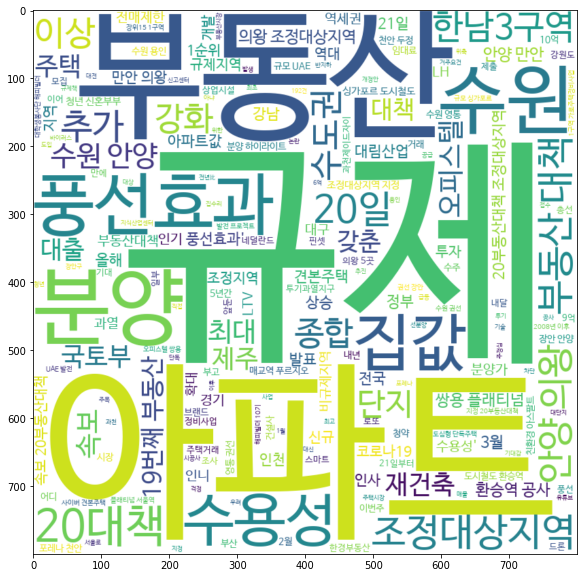

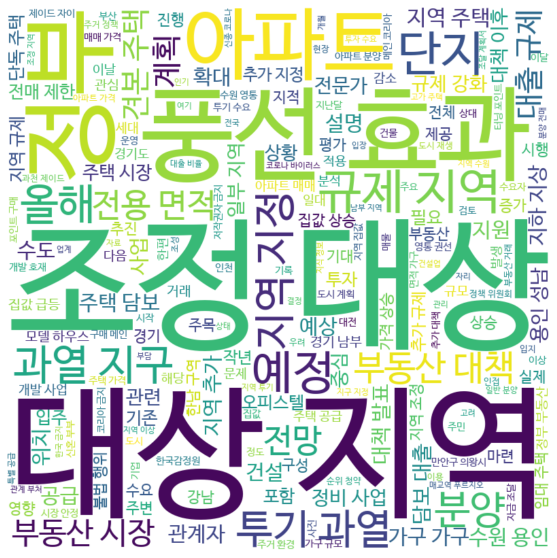

In [19]:
stopwords = ['등', '것', '무단', '전재', '배포', '국토', '교통부', '서울', '구독', '뉴스', '만큼', '가능', '최근',
             '머니', '투데이', '지난해', '헤럴드', '파이낸셜', '기자', '경우', '때문', '이번', '서울시', '인근', 
             '수준', '대표', '가운데', '기준', '데일리', '네이버', '언론', '뉴시스', '레터', '채널', '경제',
             '데일리_', '뉴스룸']

### 뉴스 제목과 컨텐츠 별 문서 통합
title = ""
content = ''
for i in df_news["title"]:
    title += i.replace("[^가-힣]+","")
for i in df_news['content']:
    content += i.replace("[^가-힣]+","")

    
### 형태소 분석기 Mecab 사용 (속도에 장점이 있음)
tagger = Mecab()

result = []
for i in df_news['content']:
    result.append(tagger.nouns(i))

content = []
for i in result:
    content.append(" ".join(i))
content = " ".join(content)

# 워드클라우드 한글폰트 적용을 위한 경로 설정
font_path = '/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf'

texts = title
wordcloud = WordCloud(
    background_color='white',
    font_path = font_path,
    width = 800,
    height = 800,
    stopwords = stopwords
)

wordcloud = wordcloud.generate_from_text(texts)

array = wordcloud.to_array()

fig = plt.figure(figsize=(10, 10))
plt.imshow(array, interpolation="bilinear")
plt.show()
wordcloud.to_file('./title.png')

texts = content
wordcloud = WordCloud(
    background_color='white',
    font_path = font_path,
    width = 800,
    height = 800,
    stopwords = stopwords
)

wordcloud = wordcloud.generate_from_text(texts)

array = wordcloud.to_array()

plt.figure(figsize=(10, 10))
plt.imshow(array, interpolation="bilinear")
plt.axis("off")
plt.show()
wordcloud.to_file('./content.png')

In [ ]:
# Define functions for stopwords, bigrams, trigrams and lemmatization
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stopwords] for doc in texts]
 
def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]
 
def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]
 
def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent))
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):   
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=num_topics, id2word=id2word)
        model_list.append(model)
    coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
    coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))

data_words = list(sent_to_words(result))

data_words[0:1]


# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)
 
# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)
 
# See trigram example
print(trigram_mod[bigram_mod[data_words[0]]])

# Remove Stop Words
data_words_nostops = remove_stopwords(data_words)
 
# Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)
 
# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
# python3 -m spacy download en
nlp = spacy.load("C:\\kyw\\Lib\\site-packages\\en_core_web_sm\\en_core_web_sm-2.2.5",
                 disable=['parser', 'ner'])
 
# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])
 
print(data_lemmatized[:1])

# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)
 
# Create Corpus
texts = data_lemmatized
 
# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]
 
# View
print(corpus[:1])

# Download File: http://mallet.cs.umass.edu/dist/mallet-2.0.8.zip
mallet_path = 'C:/Users/kosmo-18/Desktop/mallet-2.0.8/bin/mallet' # update this path
ldamallet = gensim.models.wrappers.LdaMallet(mallet_path, 
                                             corpus=corpus, 
                                             num_topics=4,           # 토픽 수 4개
                                             id2word=id2word)

In [ ]:
# LDA 모델 시각화 -> MALLET 모델은 불가능해서 LDA로 바꿔줌
lda_model = gensim.models.wrappers.ldamallet.malletmodel2ldamodel(ldamallet)
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
vis

In [ ]:
p = re.compile("[가-힣]+")
words = []
for i in range(len(lda_model.print_topics(num_words=5))):
    words.append(p.findall(lda_model.print_topics(num_words=5)[i][1]))

# words = [['올해', '공시지가', '기간', '기관', '강남구'],
#  ['진행', '견본', '건립', '계획', '시스템'],
#  ['아파트', '관계자', '분양', '포스코건설', '하우스'],
#  ['부동산', '규제', '코인', '급등', '푸르지오']]

print("""기사 주제를 크게 4가지로 나누어 각각의 키워드를 살펴본 결과입니다.
첫 번째 주제 : {0}, {1}, {2}, {3}
두 번째 주제 : {4}, {5}, {6}, {7}
세 번째 주제 : {8}, {9}, {10}, {11}
네 번째 주제 : {12}, {13}, {14}, {15}으로 나타났습니다.""".format(words[0][0], words[0][1], words[0][2], words[0][3], 
                                                                words[1][0], words[1][1], words[1][2], words[1][3], 
                                                                words[2][0], words[2][1], words[2][2], words[2][3],
                                                                words[3][0], words[3][1], words[3][2], words[3][3]))

# 아래부터는 코드가 미완성입니다. 완성본은 집에있어서 데이터셋만 만들고
# 이후 구현은 불가합니다

In [ ]:
kb_30_price # 최근 30일 등록매물 가격 (평당 평균가)
kb_30_tr_num # 최근 30일 등록매물 건수
kb_30_price_by_size # 최근 30일 규모별 등록매물 가격  (평당 평균가)
kb_30_tr_num_by_size # 최근 30일 규모별 등록매물 건수

kb_60_price # 최근 30-60일 등록매물 가격 (평당 평균가)
kb_60_tr_num # 최근 30-60일 등록매물 건수
kb_60_price_by_size # 최근 30-60일 규모별 등록매물 가격  (평당 평균가)
kb_60_tr_num_by_size # 최근 30-60일 규모별 등록매물 건수

# 위 두개 차이
kb_price_change 
kb_tr_num_change
kb_price_change_by_size
kb_tr_num_change_by_size

In [ ]:
price_change_by_gu # 구별 지난 분기 대비 이번 분기 가격 변화율
price_change_max_gu # 가장 많이 상승한 구
price_change_min_gu # 가장 많이 하락한 구

sil_30_price # 최근 30일 등록매물 가격 (평당 평균가)
sil_30_tr_num # 최근 30일 등록매물 건수
sil_30_price_by_size # 최근 30일 규모별 등록매물 가격  (평당 평균가)
sil_30_tr_num_by_size # 최근 30일 규모별 등록매물 건수

sil_60_price # 최근 30-60일 등록매물 가격 (평당 평균가)
sil_60_tr_num_by_size # 최근 30-60일 등록매물 건수
sil_60_price_by_size # 최근 30-60일 규모별 등록매물 가격  (평당 평균가)
sil_60_tr_num_by_size # 최근 30-60일 규모별 등록매물 건수

# 위 두개 차이
sil_price_change 
sil_tr_num_change
sil_price_change_by_size
sil_tr_num_change_by_size

In [106]:
df_kb

,apt,date,area,price,pyeong,size,price_per_3.3
0,개포6차우성 6동,20200221,67,159000.0,20.303030,중대형,7831.0
1,개포1차지구(주공1단지) 78동,20200220,50,175000.0,15.151515,중소형,11550.0
2,래미안블레스티지 215동,20200220,99,300000.0,30.000000,초대형,10000.0
3,래미안블레스티지 214동,20200220,126,365000.0,38.181818,초대형,9560.0
4,래미안블레스티지 209동,20200220,59,200000.0,17.878788,중소형,11186.0
...,...,...,...,...,...,...,...
1261,래미안블레스티지 209동,20191115,49,191000.0,14.848485,중소형,12863.0
1262,대치 215동,20190623,33,81000.0,10.000000,중소형,8100.0
1263,현대빌라트 1동,20190121,164,120000.0,49.696970,초대형,2415.0
1264,대치 214동,20180304,33,76000.0,10.000000,중소형,7600.0


# 기사문 작성

In [ ]:
news_text = """{0}의 {1}년 {2}월 {3}일 1주일 이내 아파트 신규 등록 매물 {4}건, 매매거래량 {5}건을 기록했다. 평형별 내역의 경우 중소형(59m2 이하)의 등록 매물은 {6}건, 3.3m2당 가격은 {7}만원으로 지난 주 대비 {8}만원 하락했다. 매매거래량은 {9}건, 3.3m2당 가격은 {10}만원으로 지난 주 대비 {11}만원 증가했다. 중대형(59m2 초과 84m2 이하)의 등록 매물은 {12}건, 3.3m2당 가격은 {13}만원으로 지난 주 대비 {14}만원 하락했다. 매매거래량은 {5}건, 3.3m2당 가격은 {16}만원으로 지난 주 대비 {17}만원 증가했다. 대형(84m2 초과)의 등록 매물은 {18}건, 3.3m2당 가격은 {19}만원으로 지난 주 대비 {20}만원 증가했다. 매매거래량은 {21}건, 3.3m2당 가격은 {22}만원으로 지난 주 대비 {23}만원 증가했다.""".format('서울시 강남구 개포동', # 0
        datetime.today().year,  # 1
        datetime.today().month, # 2
        datetime.today().day, # 3
        kb_this_wk_trade_num, # 4
        this_wk_trade_num, #5
        kb_this_wk_trade_num_by_size['count'][1], # 6
        abs(int(kb_this_wk_price_by_size['price_per_3.3'][1])), # 7
        abs(int(kb_price_change_by_size.loc[1][0])), # 8
        this_wk_trade_num_by_size['count'][1], #9
        abs(int(this_wk_price_by_size['price_per_3.3'][1])), # 10
        abs(int(price_change_by_size.loc[1][0])), # 11
        kb_this_wk_trade_num_by_size['count'][0], # 12
        abs(int(kb_this_wk_price_by_size['price_per_3.3'][0])), # 13
        abs(int(kb_price_change_by_size.loc[0][0])), # 14
        this_wk_trade_num_by_size['count'][0], # 15
        abs(int(this_wk_price_by_size['price_per_3.3'][0])), # 15
        abs(int(price_change_by_size.loc[0][0])), # 16
        kb_this_wk_trade_num_by_size['count'][2],
        abs(int(kb_this_wk_price_by_size['price_per_3.3'][2])), # 17
        abs(int(kb_price_change_by_size.loc[2][0])), # 18
        this_wk_trade_num_by_size['count'][2], # 19
        abs(int(this_wk_price_by_size['price_per_3.3'][2])), # 20
        abs(int(price_change_by_size.loc[2][0]))) # 21)

In [ ]:
news_text

In [ ]:
price_change_by_dong.sort_values(by='price_change')

In [ ]:
news_text2 = """이번 주 기준 Hot & Cool Zone 알림이입니다.
            현 분기 대비 전 분기의 실거래가 가격 등락이 가장 높은 지역은 도봉구로 10.6% 상승했습니다. 
            반면 하락률이 가장 높은 지역은 서초구로 11.2% 감소했습니다."""
news_text2

In [ ]:
text_1 = news_text[:69]
text_2 = news_text[70:200]
text_3 = news_text[201:326]
text_4 = news_text[327:]

In [ ]:
# 부동산뉴스 크롤링 후 토픽모델링 결과
words = [['올해', '공시지가', '기간', '기관', '강남구'],
 ['진행', '견본', '건립', '계획', '시스템'],
 ['아파트', '관계자', '분양', '포스코건설', '하우스'],
 ['부동산', '규제', '코인', '급등', '푸르지오']]

topic = """기사 주제를 크게 4가지로 나누어 각각의 키워드를 살펴본 결과입니다.
첫 번째 주제 : {0}, {1}, {2}, {3}
두 번째 주제 : {4}, {5}, {6}, {7}
세 번째 주제 : {8}, {9}, {10}, {11}
네 번째 주제 : {12}, {13}, {14}, {15}으로 나타났습니다.""".format(words[0][0], words[0][1], words[0][2], words[0][3], 
                                                                words[1][0], words[1][1], words[1][2], words[1][3], 
                                                                words[2][0], words[2][1], words[2][2], words[2][3],
                                                                words[3][0], words[3][1], words[3][2], words[3][3])

# 실거래가 추이 차트 그리기

In [ ]:
wk_1.strftime("%Y%m%d")

In [ ]:
df_sil_trade2.sort_values(by='week')

In [ ]:
w = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13]
n = df_sil_trade2.groupby('week', as_index=False).count()['si']
p = df_sil_trade2.groupby('week', as_index=False).median()['price_per_3.3']


In [ ]:
#폰트 경로
font_path = 'C:\\WINDOWS\\Fonts\\NanumBarunGothic.ttf'
#폰트 이름 얻어오기ma
font_name = font_manager.FontProperties(fname=font_path).get_name()
#font 설정
matplotlib.rc('font',family=font_name)

fontprop = fm.FontProperties(fname=font_path, size=12)

w = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13]
n = df_sil_trade2.groupby('week', as_index=False).count()['si']
p = df_sil_trade2.groupby('week', as_index=False).median()['price_per_3.3']



fig, ax1 = plt.subplots()

ax2 = ax1.twinx()
ax1.bar(w, n, width=0.5, color ='skyblue')
ax2.plot(w, p, 'g-', linewidth=2, color = 'blue')
ax1.legend(loc=1, borderaxespad=1.).set_zorder(2)
ax2.legend(loc=(2), borderaxespad=1.).set_zorder(2)

ax1.set_ylim([0,25])
ax2.set_ylim([4000,13000])

plt.title('서울시 강남구 개포동 지난 3개월간 변동 (2020.02.18)', 
          fontproperties=fontprop, y=1.1)


x, y, z = 0,0,0
curve1, = ax1.plot(x, y, label="Price", color='blue')
curve2, = ax2.plot(x, z, label="number", color='skyblue')
curves = [curve1, curve2]
ax1.legend(curves, [curve.get_label() for curve in curves])

plt.ylabel('단위(만원)', position=(3,1.1), rotation=1,fontproperties=fontprop )
plt.show()




# ax2.legend(curves, [curve.get_label() for curve in curves]) # also valid

# Global figure properties

# 트위터 업로드 실행

In [ ]:
imagepath = "C:\\Users\\kosmo-18\\Desktop\\2차 프로젝트_부동산 알림이 결과물\\plot.png"
titlecloud = "C:\\Users\\kosmo-18\\Documents\\카카오톡 받은 파일\\w2.png"
naecloud = "C:\\Users\\kosmo-18\\Documents\\카카오톡 받은 파일\\w1.png"
api.update_with_media(imagepath,text_1)
texts = [text_2,text_3,text_4]
time.sleep(5)
twts = api.search(q='서울시 강남구 개포동')
count = 0
for twt in twts:
    sn = twt.user.screen_name
    if sn == "yunjisang854":
        for i in texts:
            s = api.update_status(i, twt.id)
        api.update_with_media(titlecloud, "해당 기간 뉴스 제목의 출현 단어 정보입니다.", twt.id)
        api.update_with_media(naecloud, "해당 기간 뉴스의 출현 단어 정보입니다.", twt.id)
        api.update_status(topic, twt.id)
        break

# 텔레그램 봇

In [ ]:
#pip install python-telegram-bot --upgrade
import requests
import os
import json
token = '1094306699:AAEYakZrR5neqpG4x1oODcSr_okC0U28hfQ'

# 아래의 주소를 호출하면, 업데이트 된 봇의 내용을 가져올 수 있다.
url = 'https://api.telegram.org/bot{}/getUpdates'.format(token)
response = json.loads(requests.get(url).text) # json으로 받기

# 아래의 주소를 이용하면 Bot을 통해 메세지를 전송할 수 있다.
send_url = 'https://api.telegram.org/bot{}/sendMessage'.format(token)

# 나의 chat_id와, msg를 getUpdates 통해 가져온 json데이터를 파싱해서 가져온다.
chat_id = response["result"][-1]["message"]["from"]["id"]
first = '안녕하세요 부동산 봇입니다. 정보를 원하시는 시군구 및 동명을 입력해주세요 \n(xx시 xx구 xx동)'
requests.get(send_url, params = {"chat_id" : chat_id, "text" : first})
response = json.loads(requests.get(url).text) # json으로 받기
text2 = response["result"][-1]["message"]["text"]
time.sleep(2)

second = '얼마나 자주 보내드릴까요?\n (매일 / 1주일 / 한달)'
requests.get(send_url, params = {"chat_id" : chat_id, "text" : second})
text3 = response["result"][-1]["message"]["text"]
time.sleep(2)
requests.get(send_url, params = {"chat_id" : chat_id, "text" : news_text})
requests.get(send_url, params = {"chat_id" : chat_id, "text" : news_text2})
text4 = response["result"][-1]["message"]["text"]


In [ ]:
 response["result"][-1]["message"]["text"]

# 네이버 부동산 포스팅 자동화 봇

In [ ]:
import xmlrpc.client
    
    
    API_URL = 'https://api.blog.naver.com/xmlrpc'
    user_id = 'quick3505'
    api_key = '4fa32b1987a9cd996e3c6eb5a69474c0'
    
    class NaverBlog(object):
        def __init__(self, user_id, api_key):
            self.__server = None
            self.__user_id = user_id
            self.__api_key = api_key
            self.__categories = []
    
            try:
                self.__set_categories()
            except Exception as e:
                raise e
    
        def __client(self):
            if self.__server is None:
                self.__server = xmlrpc.client.ServerProxy(API_URL)
    
            return self.__server
    
        def __set_categories(self):
            categories = self.__client().metaWeblog.getCategories(self.__user_id,
                                                                self.__user_id,
                                                                self.__api_key)
    
            for category in categories:
                self.__categories.append(category['title'])
    
        def post(self, title, description, category, publish=True):
            struct = {}
            struct['title'] = title
            struct['description'] = description
            if category in self.__categories:
                struct['categories'] = [category]
    
            try:
                return self.__client().metaWeblog.newPost(self.__user_id,
                                                        self.__user_id,
                                                        self.__api_key,
                                                        struct,
                                                        publish)
            except Exception as e:
                raise e
    
    
    
    def main():
        naver = NaverBlog('아이디', '발급받은 API 암호')
        naver.post('테스트 제목', "<h1>테스트 글쓰기</h1>", '카테고리 한글')
    
    if __name__ == '__main__':
        main()